In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

users_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
engagement_df = pd.read_csv('takehome_user_engagement.csv', encoding='ISO-8859-1')

In [22]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [23]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [24]:


# Convert timestamp columns to datetime objects
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Calculate user activity duration
users_df['activity_duration'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days

def identify_adopted_user(user_engagement):
    user_engagement.sort_values(by='time_stamp', inplace=True)
    user_engagement['time_diff'] = user_engagement['time_stamp'].diff()
    
    # Calculate the rolling count of logins within a 7-day window
    user_engagement['rolling_count'] = user_engagement['time_diff'].apply(lambda x: 1 if x <= timedelta(days=7) else 0).rolling(window=3).sum()

    return any(user_engagement['rolling_count'] >= 3)

adopted_users = []
for user_id, user_data in engagement_df.groupby('user_id'):
    if identify_adopted_user(user_data):
        adopted_users.append(user_id)

# Create a column indicating whether a user is adopted
users_df['adopted'] = users_df['object_id'].isin(adopted_users).astype(int)

# Feature Engineering
users_df['creation_source'] = users_df['creation_source'].astype('category')
users_df['opted_in_to_mailing_list'] = users_df['opted_in_to_mailing_list'].astype(int)
users_df['enabled_for_marketing_drip'] = users_df['enabled_for_marketing_drip'].astype(int)

# days between first and last login
login_dates = engagement_df.groupby('user_id')['time_stamp'].agg(['min', 'max'])
users_df['days_between_logins'] = (login_dates['max'] - login_dates['min']).dt.days

# average time between logins
login_diffs = engagement_df.groupby('user_id')['time_stamp'].diff().mean()
users_df['avg_time_between_logins'] = login_diffs / np.timedelta64(1, 'D')

# was the user invited by another user
users_df['invited_by_user'] = ~users_df['invited_by_user_id'].isnull()

# summary
users_df.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,activity_duration,adopted,days_between_logins,avg_time_between_logins,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0,NaN,2.580078,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0,1,0.0,2.580078,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0,136.0,2.580078,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0,0.0,2.580078,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,0,0.0,2.580078,True


In [25]:
users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
activity_duration             3177
adopted                          0
days_between_logins           3178
avg_time_between_logins          0
invited_by_user                  0
dtype: int64

In [26]:
# Fill missing values in specific columns
users_df['last_session_creation_time'].fillna(pd.Timestamp('1970-01-01'), inplace=True)
users_df['invited_by_user_id'].fillna(-1, inplace=True)
users_df['activity_duration'].fillna(0, inplace=True)
users_df['days_between_logins'].fillna(0, inplace=True)

users_df.isna().sum()


object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
activity_duration             0
adopted                       0
days_between_logins           0
avg_time_between_logins       0
invited_by_user               0
dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Encode categorical features
label_encoder = LabelEncoder()
users_df['creation_source'] = label_encoder.fit_transform(users_df['creation_source'])

# Split the data into features (X) and target (y)
features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
            'activity_duration', 'days_between_logins', 'avg_time_between_logins', 'invited_by_user']
X = users_df[features]
y = users_df['adopted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2084
           1       0.89      0.90      0.89       316

    accuracy                           0.97      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.97      0.97      0.97      2400



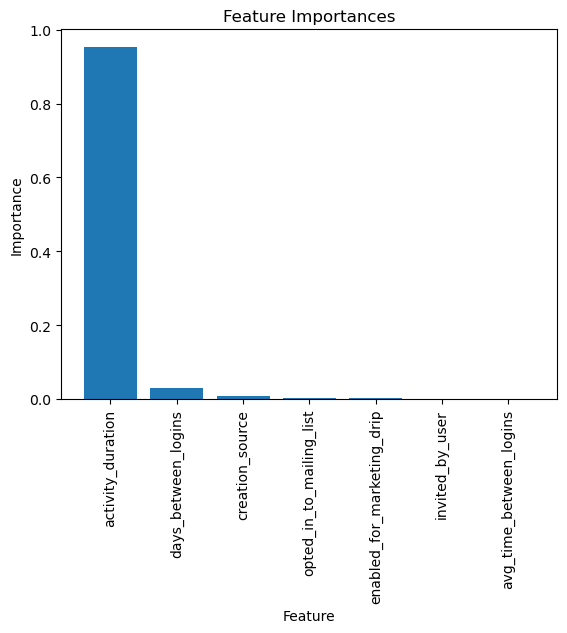

In [28]:
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns

# Sort and plot feature importances
sorted_idx = feature_importances.argsort()[::-1]
plt.bar(range(X.shape[1]), feature_importances[sorted_idx])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


In [29]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_classifier, X_test_scaled, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

for i in sorted_idx:
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f}")


activity_duration: 0.1991
opted_in_to_mailing_list: 0.0016
enabled_for_marketing_drip: 0.0003
avg_time_between_logins: 0.0000
days_between_logins: -0.0007
creation_source: -0.0010
invited_by_user: -0.0022


The model seemed to be fairly accurate at correctly identifying the 'Not Adopted' class, and slightly less accruate with the 'Adopted' class. Overall, the model performs exceptionally well with high precision, recall, and F1-scores for both classes. The accuracy of 0.97 indicates that the model is effective in classifying users as "Adopted" or "Not Adopted." The high F1-scores for both classes suggest that the model strikes a good balance between precision and recall. This indicates a well-performing model that can accurately predict user adoption based on the given features.

The most important feature for the model is the acitivity_duration feature which makes sense since those people are going to be more engaged on the site. 

Further Research and Data:

Improve Prediction for "Adopted" Class: Since the model's performance is slightly lower for the "Adopted" class, consider collecting additional data related to user engagement, behavior, or interactions within the product. More detailed user activity data might help improve predictions for the "Adopted" class.

User Engagement Patterns: Dive deeper into user engagement patterns to identify common behaviors among "Adopted" users. Are there specific actions, features, or activities that tend to be more prevalent among users who become adopted? This understanding can guide product enhancements.

Survey Data: Collect survey data from users to gain insights into their motivations, expectations, and experiences with the product. Qualitative data can provide a richer understanding of user behaviors and preferences.

A/B Testing: Implement A/B testing to experiment with different features, onboarding processes, or marketing strategies to assess their impact on user adoption rates.

These different tests and analyses could help determine better ways to raise user engagement and ultimately improve model accuracy. 